In [1]:
# !pip install stable-baselines3[extra]

In [2]:
import gymnasium as gym

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from tqdm import tqdm

In [4]:
from typing import Type, List

from AgentBasedModel.exchange import ExchangeAgent, Asset
from AgentBasedModel.traders import (
    Trader,
    Universalist,
    Chartist1D,
    Chartist2D,
    Fundamentalist,
    SingleTrader,
)
from AgentBasedModel.extra import Event
from AgentBasedModel.utils.math import mean, std, rolling

import random
from tqdm import tqdm

In [5]:
from AgentBasedModel import *
from AgentBasedModel.extra import *
from AgentBasedModel.visualization import *
from AgentBasedModel.visualization.other import plot_book
from AgentBasedModel.visualization.other import plot_full_book
from AgentBasedModel.visualization.trader import *
from random import randint

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [7]:
run utils_nikita//functions.ipynb

# RL trading agent

In [8]:
class RLTrader(SingleTrader):
    def __init__(
            self,
            market: ExchangeAgent,
            timing=1,
            cash:   float | int = 1**3, #10**3,
            assets: int = 0,
            limit_inventory=100
        ):
        """
        :param market: link to exchange agent
        :param cash: trader's cash available, defaults 10**3
        :param assets: trader's number of shares hold, defaults 0
        :param access: number of future dividends known, defaults 0 (knows only current dividend)
        """
        super().__init__(market, cash, assets)
        self.type = 'RLTrader'
        
        self.timing = timing
        self.limit_inventory = limit_inventory
        self.last_move = 0
        
        self.last_cash = self.cash
        self.last_assets = self.assets
        
        self.last_qty_bid = 0
        self.last_qty_ask = 0
        
        self.last_price_ask = 0
        self.last_price_bid = 0
    
    def call(self, action): # bid, ask qty. bid, ask price

        self.last_cash = self.cash
        self.last_assets = self.assets
        
        bid_price = self.market.order_book['bid'].to_list()[0]['price']
        ask_price = self.market.order_book['ask'].to_list()[0]['price']
        
        bid_qty_action = action[0] * 10
        ask_qty_action = action[1] * 10
        
        bid_price_action = action[2]
        ask_price_action = action[3]
        
        ask_price = ask_price + (bid_price_action - 5) * 0.1
        bid_price = bid_price - (ask_price_action - 5) * 0.1
        
        if self.last_move % self.timing == 0:
            
            if self.orders:
                for i in range(len(self.orders)):
                    order = self.orders[0]
                    self._cancel_order(order)
                    
            
            # Restriction on the inventory
            if ask_qty_action - self.assets > self.limit_inventory:
                ask_qty_action = self.limit_inventory + self.assets
            
            if bid_qty_action + self.assets > self.limit_inventory:
                bid_qty_action = self.limit_inventory - self.assets
            
            
            if self.assets >= -1 * self.limit_inventory and ask_qty_action > 0:
                self._sell_limit(ask_qty_action, ask_price)
            
            if self.assets <= self.limit_inventory and bid_qty_action > 0:
                self._buy_limit(bid_qty_action, bid_price)
            
            self.last_qty_ask = ask_qty_action
            self.last_qty_bid = bid_qty_action
            
            self.last_price_ask = ask_price
            self.last_price_bid = bid_price
            
#             print('ask', ask_qty_action, ask_price)
#             print('bid', bid_qty_action, bid_price)
            
        self.last_move += 1

# Simulator-gym

In [9]:
rewards_container = []

agent_states_container = []

In [10]:
class Simulator_gym(gym.Env):
    """
    Simulator is responsible for launching agents' actions and executing scenarios
    """
    # todo: Only traders are to be passed, trader -> trader.exchange -> trader.exchange.asset. Use dict comprehension to get unique items.
    def __init__(
            self,
            assets:    List[Type[Asset]],
            exchanges: List[ExchangeAgent],
            traders:   List[Type[Trader]],
            events:    List[Type[Event]] = None,
            
            observation_space = None,
            action_space = None,
        
            random_seed = None,
            
            SGU = None,
            device = 'cuda'
        ):
        
        super(Simulator_gym, self).__init__()
        
        self.assets = assets
        self.exchanges = exchanges
        self.traders = traders
        self.events = [event.link(self) for event in events] if events else None  # link all events to simulator

        self.info = SimulatorInfo(exchanges, traders)
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.called_traders = set()
        self.initial_call = 0
        
        self.random_seed = random_seed
        self.device = device
        
        self.RL_agent = None
        
        self.FC = FeatureCollector(self.info, self.exchanges[0])
        
        self.SGU = SGU
        
    def get_reward(self):
        if not self.RL_agent:
            return 0
        
        current_ask_qty = 0
        current_bid_qty = 0
        
        current_ask_price = 0
        current_bid_price = 0
        
        for i in range(len(self.RL_agent.orders)):
            
            order = self.RL_agent.orders[i]
            
            if order.order_type == 'ask':
                current_ask_qty = order.qty
                
            elif order.order_type == 'bid':
                current_bid_qty = order.qty
                
        current_ask_price = self.RL_agent.last_price_ask
        current_bid_price = self.RL_agent.last_price_bid
        
        executed_asks = self.RL_agent.last_qty_ask - current_ask_qty
        executed_bids = self.RL_agent.last_qty_bid - current_bid_qty
        
        reward = min(executed_asks, executed_bids) * (current_ask_price - current_bid_price) / 5
        reward = reward - (abs(self.RL_agent.last_assets - (executed_asks - executed_bids)) / (self.RL_agent.limit_inventory))
        
        # [200.5, 20, 90, 201.4, 0],
        
        rewards_container.append([reward, executed_asks, executed_bids, current_ask_price, current_bid_price])
        
        agent_states_container.append([self.RL_agent.assets, self.RL_agent.cash, self.RL_agent.equity()])
        
        return reward
        
        
#         delta_cash = self.RL_agent.cash - self.RL_agent.last_cash
#         delta_assets = self.RL_agent.assets - self.RL_agent.last_assets

#         return delta_cash - abs(self.RL_agent.last_assets + delta_assets)/self.RL_agent.limit_inventory
            
#             return delta_cash - 0.1 * (self.RL_agent.assets + delta_assets)
#             return (self.RL_agent.cash + self.RL_agent.assets * self.exchanges[0].price()) - 10**3 - abs(self.RL_agent.assets)
        

    def simulate(self, n_iter: int, silent: bool = False) -> object:
        
        for it in tqdm(range(n_iter), desc='Simulation', disable=silent):
            
            # Call scenario
            if self.events:
                for event in self.events:
                    event.call(it)

            # Capture current info
            self.info.capture()

            # Call Traders
            random.shuffle(self.traders)
            

            for trader in self.traders:
                if type(trader) == Universalist:
                    trader.change_strategy(self.info)
                if type(trader) in (Universalist, Chartist1D, Chartist2D):
                    trader.change_sentiment(self.info)
                if type(trader) == RLTrader:
                    continue

                trader.call()    # trader's action
            
            # Pay Traders
            for trader in self.traders:
                trader.income()  # trader's dividend and interest

            # Update assets
            for asset in self.assets:
                asset.update()  # generate next dividend
        
            for exchange in self.exchanges:
                exchange.transactions.iteration += 1
        
        return self
    
    def reset(self, seed=None, options=None):
        
        self.random_seed += 1001
        
        market_agents=[40, 40, 40, 1]
        dividend = 10
        risk_free_rate = 0.05
        price = 200
        
        random.seed(self.random_seed)

        assets = [Stock(dividend)]

        simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)

        simple_traders = [
            *[Random(simple_exchange) for _ in range(market_agents[0])],
            *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
            *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
            *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
            *[RLTrader(simple_exchange)]
        ]
        
        self.assets = assets
        self.exchanges = [simple_exchange]
        self.traders = simple_traders
        self.events = None
        
        self.info = SimulatorInfo(self.exchanges, self.traders)
        
        self.called_traders = set()
        self.initial_call = 0
        
        self.RL_agent = None
        
        self.simulate(1, silent=False)
        print('reset')
        
        self.FC = FeatureCollector(self.info, self.exchanges[0])
        
        features = self.FC.get_features()
        
        if self.SGU:
            features = torch.Tensor(features.values).to(self.device)
            signals = self.SGU(features)
            observations = np.array(signals.detach().to('cpu'), dtype='float32')

        else:
            features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
            observations = np.array(features.values[0], dtype='float32')
                        
        observations = np.append(observations, np.float32(0))
        
        reward = self.get_reward()
        terminated = False
        truncated = False
        info = dict()
        
#         print(observations)
        return observations, info
        
        
    def step(self, action):
        
        if self.initial_call == 0:
            self.simulate(1, silent=False)
        
        if self.initial_call == 1:
            trader = self.RL_agent
            trader.call(action)
            self.called_traders.add(trader)
        
        self.initial_call = 1
        
        for trader in self.traders:
            if trader in self.called_traders:
                pass
            
            else:
                if type(trader) == Universalist:
                    trader.change_strategy(self.info)
                if type(trader) in (Universalist, Chartist1D, Chartist2D):
                    try:
                        trader.change_sentiment(self.info)
                    except:
                        pass
                if type(trader) == RLTrader:
                    
                    self.RL_agent = trader
                    
                    features = self.FC.get_features()
                    
                    if self.SGU:
                        features = torch.Tensor(features.values).to(self.device)
                        signals = self.SGU(features)
                        observations = np.array(signals.detach().to('cpu'), dtype='float32')
                    
                    else:
                        features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
                        observations = np.array(features.values[0], dtype='float32')
                        
                    observations = np.append(observations, np.float32(self.RL_agent.assets))

                    reward = self.get_reward()
                    
                    terminated = False
                    truncated = False
                    info = dict()
                    
#                     print(observations)
                    return observations, reward, terminated, truncated, info

                trader.call()
        
        # Finish cycle
        # Pay Traders
        for trader in self.traders:
            if type(trader) == RLTrader:
                continue
            else:
                trader.income()  # trader's dividend and interest

        # Update assets
        for asset in self.assets:
            asset.update()  # generate next dividend

        for exchange in self.exchanges:
            exchange.transactions.iteration += 1
        
        # Start new cycle
        
        # Call scenario
        if self.events:
            for event in self.events:
                event.call(it)

        # Capture current info
        self.info.capture()

        # Call Traders
        random.shuffle(self.traders)
        
        self.called_traders = set()
        
        for trader in self.traders:
            if type(trader) == Universalist:
                trader.change_strategy(self.info)
            if type(trader) in (Universalist, Chartist1D, Chartist2D):
                try:
                    trader.change_sentiment(self.info)
                except:
                    pass
            if type(trader) == RLTrader:
                
                self.RL_agent = trader
                
                features = self.FC.get_features()
                    
                if self.SGU:
                    features = torch.Tensor(features.values).to(self.device)
                    signals = self.SGU(features)
                    observations = np.array(signals.detach().to('cpu'), dtype='float32')

                else:
                    features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
                    observations = np.array(features.values[0], dtype='float32')

                observations = np.append(observations, np.float32(self.RL_agent.assets))
                    
                reward = self.get_reward()
                terminated = False
                truncated = False
                info = dict()
                
#                 print(observations)
                return observations, reward, terminated, truncated, info

            trader.call()    # trader's action
            self.called_traders.add(trader)

# Environment setup

In [11]:
# simulator settings
market_agents=[40, 40, 40, 1]
random_state = 21140
dividend = 10
risk_free_rate = 0.05
price = 200

# gym settings

# observation space
obs_space = gym.spaces.Box(-1, 1, shape=(17,), seed=21)

# action space
# action_space = gym.spaces.MultiDiscrete(np.array([151, 151, 101, 101]), seed=22) # bid, ask qty. bid, ask price
action_space = gym.spaces.MultiDiscrete(np.array([10, 10, 16, 16]), seed=22) # bid, ask qty. bid, ask price

# gym definition
random.seed(random_state)

assets = [Stock(dividend)]

simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)

simple_traders = [
    *[Random(simple_exchange) for _ in range(market_agents[0])],
    *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
    *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
#     *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
    *[RLTrader(simple_exchange)]
]

# simple_sim = Simulator(**{
#     'assets': [assets[0]],
#     'exchanges': [simple_exchange],
#     'traders': simple_traders[:-1]
# })

my_gym = Simulator_gym(**{
    'assets': [assets[0]],
    'exchanges': [simple_exchange],
    'traders': simple_traders}, 
                       
    observation_space = obs_space,
    action_space = action_space,
    random_seed = random_state,)

In [12]:
random.seed(random_state)

assets = [Stock(dividend)]

simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)

simple_traders = [
    *[Random(simple_exchange) for _ in range(market_agents[0])],
    *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
    *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
    *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
    *[RLTrader(simple_exchange)]
]

simple_sim = Simulator(**{
    'assets': [assets[0]],
    'exchanges': [simple_exchange],
    'traders': simple_traders[:-1]
})

In [13]:
simple_sim = Simulator(**{
    'assets': [assets[0]],
    'exchanges': [simple_exchange],
    'traders': simple_traders[:-1]
})

In [14]:
ag_1 = RLTrader(simple_exchange)

In [15]:
ag_1.equity()

1.0

In [16]:
# from stable_baselines3.common.env_checker import check_env

In [17]:
# check_env(my_gym, warn=True)

# Classification model for transfer learning

In [18]:
class SimpleModel(nn.Module):
    def __init__(self):
        
        super(SimpleModel, self).__init__()
        
        self.linear = nn.Linear(16, 30)
        self.linear2 = nn.Linear(30, 20)
        self.linear3 = nn.Linear(20, 10)
        self.linear4 = nn.Linear(10, 3)
        
#         self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.softmax(x)
        
        return x

In [19]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [21]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [22]:
simple_model = SimpleModel()
# simple_model.load_state_dict(torch.load('models/simple_model_shift_5_no_lob_25_may')) # lag 5
simple_model.load_state_dict(torch.load('models/simple_model_shift_1_no_lob_25_may')) # lag 1


class customFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, downloading_path='models/simple_model_shift_1_no_lob_25_may', observation_space = None):
        
        super(customFeatureExtractor, self).__init__(observation_space = observation_space, features_dim=11)
        
        self.base = simple_model
        
        for param in self.base.parameters():
            param.requires_grad = False
            
        self.base.linear4 = nn.Linear(10, 10)
        
        self.base.softmax = Identity()
        
#         self.features_dim = 11
        self.observation_space = observation_space
    
    def forward(self, x):
        
        if len(x.size()) == 1:
#             print(x, x[-1])
#             print(x.size())

            features = torch.Tensor(x[:-1]).to('cuda')
            inventory = torch.Tensor([x[-1]]).to('cuda')

            features = self.base(features)

            x = torch.cat([features, inventory])
            
            return x.unsqueeze(0)
            
        else:
            
            features = [x[i][:-1].unsqueeze(0) for i in range(x.size()[0])]
            inventory = [[x[i][-1]] for i in range(x.size()[0])]
            
            features = torch.cat(features, dim=0).to('cuda')
            inventory = torch.Tensor(inventory).to('cuda')

            features = self.base(features)
    
            correct_data = []

            for i in range(features.size()[0]):
                correct_data.append(torch.cat([features[i], inventory[i]]).unsqueeze(0))

            x = torch.cat(correct_data, dim=0)
        
            return x.to('cuda')

In [23]:
SGU = customFeatureExtractor(downloading_path='models/simple_model_shift_1_no_lob_25_may', observation_space=obs_space)

In [25]:
for p in SGU.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
True
True


In [26]:
SGU.to('cuda');

In [27]:
SGU.train();

# Check simulation

In [28]:
# actions_ = actions_[:-1]

In [29]:
# len(actions_)

In [30]:
# iterat = 0
# my_gym.reset()

# for el in actions_:
#     my_gym.step(el)
#     iterat += 1
    
#     if iterat > 53:
#         plot_full_book(my_gym.info, idx=my_gym.exchanges[0].id)

# Training

In [31]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan

In [32]:
# Instantiate the env
# vec_env = make_vec_env(Simulator_gym, n_envs=1, env_kwargs=dict())

In [34]:
obs_space = gym.spaces.Box(-1, 1, shape=(17,), seed=random_state)

In [35]:
obs_space

Box(-1.0, 1.0, (17,), float32)

In [36]:
def make_env(seed=2509, no_mm=True, SGU=None):
    
    if no_mm:
        market_agents=[40, 40, 40, 0]
    else:
        market_agents=[40, 40, 40, 1]
    
    random_state = seed
    dividend = 10
    risk_free_rate = 0.05
    price = 200

    # gym settings

    # observation space
    if SGU:
        obs_space = gym.spaces.Box(-1, 1, shape=(17,), seed=random_state)
    else:
        obs_space = gym.spaces.Box(-1, 1, shape=(17,), seed=random_state)

    # action space
    action_space = gym.spaces.MultiDiscrete(np.array([10, 10, 16, 16]), seed=random_state) # bid, ask qty. bid, ask price
    
    random.seed(random_state)

    assets = [Stock(dividend)]

    simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)
    
    simple_traders = [
    *[Random(simple_exchange) for _ in range(market_agents[0])],
    *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
    *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
    *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
    *[RLTrader(simple_exchange)]
    ]
    
    
#     settings = {
#         'assets': [assets[0]],
#         'exchanges': [simple_exchange],
#         'traders': simple_traders, 

#         'observation_space': obs_space,
#         'action_space': action_space,
#         'random_seed': random_state,
#     }

    my_gym = Simulator_gym(**{
        'assets': [assets[0]],
        'exchanges': [simple_exchange],
        'traders': simple_traders}, 

        observation_space = obs_space,
        action_space = action_space,
        random_seed = random_state,
        SGU=SGU,
        )
    
    return my_gym
#     return settings

In [37]:
# my_gym = Simulator_gym(**{
#     'assets': [assets[0]],
#     'exchanges': [simple_exchange],
#     'traders': simple_traders}, 
                       
#     observation_space = obs_space,
#     action_space = action_space,
#     random_seed = random_state,)

# env = SubprocVecEnv([lambda: Simulator_gym(**{
#     'assets': [assets[0]],
#     'exchanges': [simple_exchange],
#     'traders': simple_traders}, 
                       
#     observation_space = obs_space,
#     action_space = action_space,
#     random_seed = random_state,)])

# env = VecCheckNan(env, raise_exception=True)

# Training

In [40]:
from stable_baselines3.common.logger import configure

tmp_path = "/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_transfer_policy/model_lag_1_50000_may_25/"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])

my_env = DummyVecEnv([make_env])

policy_kwargs = dict(
    features_extractor_class=customFeatureExtractor,
    net_arch=dict(pi=[64, 64], vf=[64, 64]),
)

model = PPO("MlpPolicy", my_env, policy_kwargs=policy_kwargs, n_steps=25, verbose=1, batch_size=25)

model.set_logger(new_logger)

Using cuda device


C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
# model = PPO("MlpPolicy", my_env, n_steps=25, verbose=1, batch_size=25)
# model.set_logger(new_logger)

In [42]:
from tqdm import trange

In [43]:
capturing_index=[500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000]

for i in range(50000 // 250):
    
    model.learn(250)
    
    if i * 250 in capturing_index:
        model.save(tmp_path + f"model_{i * 250}")

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


---------------------------
| time/              |    |
|    fps             | 18 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 25 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/                  |             |
|    approx_kl            | 0.036877494 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.1       |
|    explained_variance   | -0.0148     |
|    learning_rate        | 0.0003      |
|    loss                 | 12.9        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0895     |
|    value_loss           | 27.7        |
-----------------------------------------
-----------------------------------------
| time

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008181994 |
|    clip_fraction        | 0.02        |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.1       |
|    explained_variance   | 0.0422      |
|    learning_rate        | 0.0003      |
|    loss                 | 9.86        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0336     |
|    value_loss           | 21.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.09it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009700468 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10         |
|    explained_variance   | -2.5        |
|    learning_rate        | 0.0003      |
|    loss                 | 3.27        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0347     |
|    value_loss           | 8.09        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 100.08it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.05955349 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.92      |
|    explained_variance   | 0.114      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.61       |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0778    |
|    value_loss           | 3.56       |
----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 23        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 50        |
| train/              

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.023700055 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.78       |
|    explained_variance   | -0.419      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.8         |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0718     |
|    value_loss           | 4.54        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 256.66it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013074846 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.35       |
|    explained_variance   | 0.00121     |
|    learning_rate        | 0.0003      |
|    loss                 | 7.05        |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0366     |
|    value_loss           | 15.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.040068634 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.6        |
|    explained_variance   | -0.103      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.09        |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.0723     |
|    value_loss           | 2.62        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.19it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.040033057 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.83       |
|    explained_variance   | -0.108      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.18        |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.0679     |
|    value_loss           | 0.739       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.07it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.016641833 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.05       |
|    explained_variance   | -0.0395     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.37        |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 7.11        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 20        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 50        |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 274.50it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.26it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.090650566 |
|    clip_fraction        | 0.384       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.58       |
|    explained_variance   | 0.0105      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.17        |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.0995     |
|    value_loss           | 0.697       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.033492137 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.88       |
|    explained_variance   | -0.0233     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0356      |
|    n_updates            | 1000        |
|    policy_gradient_loss | -0.0732     |
|    value_loss           | 0.348       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.56it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.16it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0071310974 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.16        |
|    explained_variance   | 0.0811       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22         |
|    n_updates            | 1100         |
|    policy_gradient_loss | -0.035       |
|    value_loss           | 2.89         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.14it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0038401675 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.59        |
|    explained_variance   | -0.00751     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.29         |
|    n_updates            | 1200         |
|    policy_gradient_loss | -0.0211      |
|    value_loss           | 5.23         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.08736416 |
|    clip_fraction        | 0.372      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.88      |
|    explained_variance   | -1.53      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.116     |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0864    |
|    value_loss           | 0.0599     |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.11it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.021416172 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.59       |
|    explained_variance   | -3.28       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.018      |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.0579     |
|    value_loss           | 0.28        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.039147936 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.64       |
|    explained_variance   | -0.364      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00124     |
|    n_updates            | 1500        |
|    policy_gradient_loss | -0.0574     |
|    value_loss           | 0.306       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.11it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.00864772 |
|    clip_fraction        | 0.036      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.45      |
|    explained_variance   | 0.0564     |
|    learning_rate        | 0.0003     |
|    loss                 | 1.83       |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 3.94       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.98it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.10it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.042076916 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.99       |
|    explained_variance   | -0.0518     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0666     |
|    n_updates            | 1700        |
|    policy_gradient_loss | -0.0618     |
|    value_loss           | 0.0914      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.44it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.040933084 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.1        |
|    explained_variance   | -0.763      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0617     |
|    n_updates            | 1800        |
|    policy_gradient_loss | -0.0641     |
|    value_loss           | 0.115       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.96it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 149.26it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013153996 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.91       |
|    explained_variance   | -0.181      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.159       |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.0421     |
|    value_loss           | 0.498       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.026221583 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.99       |
|    explained_variance   | -0.127      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0881      |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.042      |
|    value_loss           | 0.369       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.70it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.002951982 |
|    clip_fraction        | 0.004       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.48       |
|    explained_variance   | 0.105       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.934       |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.00985    |
|    value_loss           | 2.13        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.94it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.052642692 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.42       |
|    explained_variance   | 0.495       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0739     |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.0525     |
|    value_loss           | 0.0416      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.10it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.020237159 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.4        |
|    explained_variance   | 0.29        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0781     |
|    n_updates            | 2300        |
|    policy_gradient_loss | -0.0474     |
|    value_loss           | 0.0326      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.95it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.014625661 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.09       |
|    explained_variance   | -5.4        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0738     |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0385     |
|    value_loss           | 0.144       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.23it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.44it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.015394387 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.53       |
|    explained_variance   | -0.842      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00499    |
|    n_updates            | 2500        |
|    policy_gradient_loss | -0.0394     |
|    value_loss           | 0.155       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.21it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.020801058 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.43       |
|    explained_variance   | -1.48       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0197     |
|    n_updates            | 2600        |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 0.043       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.59it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.04515992 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.32      |
|    explained_variance   | -0.131     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.081     |
|    n_updates            | 2700       |
|    policy_gradient_loss | -0.0569    |
|    value_loss           | 0.0281     |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.20it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.01it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.027768034 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | -0.577      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.085      |
|    n_updates            | 2800        |
|    policy_gradient_loss | -0.0539     |
|    value_loss           | 0.0338      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.30it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008936069 |
|    clip_fraction        | 0.044       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.05       |
|    explained_variance   | -1.06       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0351     |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.036      |
|    value_loss           | 0.104       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008694623 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.34       |
|    explained_variance   | -0.509      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0207      |
|    n_updates            | 3000        |
|    policy_gradient_loss | -0.0323     |
|    value_loss           | 0.262       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.23it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.031978276 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.65       |
|    explained_variance   | 0.0353      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0418     |
|    n_updates            | 3100        |
|    policy_gradient_loss | -0.0443     |
|    value_loss           | 0.098       |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 23        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 50        |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.54it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.23it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.027606921 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.79       |
|    explained_variance   | 0.115       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0488      |
|    n_updates            | 3200        |
|    policy_gradient_loss | -0.0571     |
|    value_loss           | 0.329       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 169.78it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.006898167 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.82       |
|    explained_variance   | -0.0595     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0782      |
|    n_updates            | 3300        |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 0.429       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.17it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.007944319 |
|    clip_fraction        | 0.02        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.16       |
|    explained_variance   | -0.0264     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.19        |
|    n_updates            | 3400        |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 2.65        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.97it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.48it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018969957 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.14       |
|    explained_variance   | -0.0343     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00589     |
|    n_updates            | 3500        |
|    policy_gradient_loss | -0.0446     |
|    value_loss           | 0.238       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.95it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.40it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0064828396 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.151        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.204        |
|    n_updates            | 3600         |
|    policy_gradient_loss | -0.0226      |
|    value_loss           | 0.702        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.38it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.025410818 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.25       |
|    explained_variance   | -0.0941     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0349      |
|    n_updates            | 3700        |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.207       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 100.28it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.034893457 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.06       |
|    explained_variance   | -0.0329     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.03        |
|    n_updates            | 3800        |
|    policy_gradient_loss | -0.032      |
|    value_loss           | 0.231       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.36it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.74it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0036582255 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.6         |
|    explained_variance   | 0.0857       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.358        |
|    n_updates            | 3900         |
|    policy_gradient_loss | -0.0181      |
|    value_loss           | 1.05         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps 

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.44it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 165.68it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.053865936 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.74       |
|    explained_variance   | -1.58       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.113      |
|    n_updates            | 4000        |
|    policy_gradient_loss | -0.0689     |
|    value_loss           | 0.0237      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.04it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.04371749 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.19      |
|    explained_variance   | 0.08       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0662    |
|    n_updates            | 4100       |
|    policy_gradient_loss | -0.0638    |
|    value_loss           | 0.0826     |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.54it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.01343981 |
|    clip_fraction        | 0.084      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.45      |
|    explained_variance   | -0.142     |
|    learning_rate        | 0.0003     |
|    loss                 | 3.06       |
|    n_updates            | 4200       |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 6.52       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.04981036 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.87      |
|    explained_variance   | -1.46      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0616    |
|    n_updates            | 4300       |
|    policy_gradient_loss | -0.0396    |
|    value_loss           | 0.0308     |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005701244 |
|    clip_fraction        | 0.004       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.21       |
|    explained_variance   | -0.235      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.479       |
|    n_updates            | 4400        |
|    policy_gradient_loss | -0.00978    |
|    value_loss           | 1.3         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.007834036 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | -1.79       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0312     |
|    n_updates            | 4500        |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 0.0348      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.56it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 124.19it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.011310303 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.24       |
|    explained_variance   | -0.421      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0676     |
|    n_updates            | 4600        |
|    policy_gradient_loss | -0.0322     |
|    value_loss           | 0.0155      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.01094728 |
|    clip_fraction        | 0.04       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.6       |
|    explained_variance   | 0.176      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.204      |
|    n_updates            | 4700       |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 0.606      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.42it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.012106533 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.38       |
|    explained_variance   | -0.544      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.102       |
|    n_updates            | 4800        |
|    policy_gradient_loss | -0.0298     |
|    value_loss           | 0.374       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.46it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.001430471 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.75       |
|    explained_variance   | -0.787      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.202       |
|    n_updates            | 4900        |
|    policy_gradient_loss | -0.00605    |
|    value_loss           | 0.498       |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 22        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 50        |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 248.96it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 26           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0068668555 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.27        |
|    explained_variance   | 0.232        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0319      |
|    n_updates            | 5000         |
|    policy_gradient_loss | -0.0145      |
|    value_loss           | 0.0261       |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.38it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.02030304 |
|    clip_fraction        | 0.072      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.21      |
|    explained_variance   | -0.222     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0536    |
|    n_updates            | 5100       |
|    policy_gradient_loss | -0.0343    |
|    value_loss           | 0.0211     |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0023340774 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.17        |
|    explained_variance   | -0.0787      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.07         |
|    n_updates            | 5200         |
|    policy_gradient_loss | 0.00243      |
|    value_loss           | 6.92         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 124.67it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005206828 |
|    clip_fraction        | 0.02        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | -0.349      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0107      |
|    n_updates            | 5300        |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.16        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.92it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.034113225 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.328       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0561     |
|    n_updates            | 5400        |
|    policy_gradient_loss | -0.0412     |
|    value_loss           | 0.0376      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.32it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.71it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.011711905 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | -4.19       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0237     |
|    n_updates            | 5500        |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 0.0981      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.052999143 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.0177      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.147       |
|    n_updates            | 5600        |
|    policy_gradient_loss | -0.057      |
|    value_loss           | 0.518       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0075868177 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.09        |
|    explained_variance   | -0.531       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0557       |
|    n_updates            | 5700         |
|    policy_gradient_loss | -0.0151      |
|    value_loss           | 0.192        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.78it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.58it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.017328737 |
|    clip_fraction        | 0.08        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.0983      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.429       |
|    n_updates            | 5800        |
|    policy_gradient_loss | -0.0299     |
|    value_loss           | 1           |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.12it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.010376518 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.00331     |
|    learning_rate        | 0.0003      |
|    loss                 | 2.04        |
|    n_updates            | 5900        |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 4.43        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.015021781 |
|    clip_fraction        | 0.044       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.58       |
|    explained_variance   | -0.658      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0496     |
|    n_updates            | 6000        |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.00715     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.68it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.05076843 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.74      |
|    explained_variance   | 0.517      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.064     |
|    n_updates            | 6100       |
|    policy_gradient_loss | -0.0415    |
|    value_loss           | 0.0187     |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0040938878 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.67        |
|    explained_variance   | -0.116       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.436        |
|    n_updates            | 6200         |
|    policy_gradient_loss | -0.0134      |
|    value_loss           | 0.97         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.21it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.29it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.03018388 |
|    clip_fraction        | 0.072      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.21      |
|    explained_variance   | -1.64      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0264    |
|    n_updates            | 6300       |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 0.146      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.15it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.63it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.016117427 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | -0.0819     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.301       |
|    n_updates            | 6400        |
|    policy_gradient_loss | -0.0189     |
|    value_loss           | 0.69        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005206439 |
|    clip_fraction        | 0.02        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.21       |
|    explained_variance   | -0.337      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.18        |
|    n_updates            | 6500        |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 0.43        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.55it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.62it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.017525189 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.18       |
|    explained_variance   | -1.57       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0375     |
|    n_updates            | 6600        |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 0.00837     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 335.14it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0036595915 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.01        |
|    explained_variance   | 0.284        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.617        |
|    n_updates            | 6700         |
|    policy_gradient_loss | -0.0145      |
|    value_loss           | 1.45         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.47it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.05541344 |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.16      |
|    explained_variance   | -0.145     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0437     |
|    n_updates            | 6800       |
|    policy_gradient_loss | -0.0455    |
|    value_loss           | 0.243      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.13it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.60it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0095219705 |
|    clip_fraction        | 0.048        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.18        |
|    explained_variance   | -1.54        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.202        |
|    n_updates            | 6900         |
|    policy_gradient_loss | -0.0211      |
|    value_loss           | 0.658        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.77it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.55it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005445387 |
|    clip_fraction        | 0.02        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.12       |
|    explained_variance   | 0.0177      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.82        |
|    n_updates            | 7000        |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 8.08        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 110.78it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 19         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.03639273 |
|    clip_fraction        | 0.104      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.12      |
|    explained_variance   | 0.287      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0626    |
|    n_updates            | 7100       |
|    policy_gradient_loss | -0.0563    |
|    value_loss           | 0.0757     |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.30it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 189.20it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.023111774 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.252       |
|    n_updates            | 7200        |
|    policy_gradient_loss | -0.03       |
|    value_loss           | 0.646       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.50it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.016612707 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | -0.357      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0311      |
|    n_updates            | 7300        |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 0.143       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 335.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.23it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.022308566 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | -0.118      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0584      |
|    n_updates            | 7400        |
|    policy_gradient_loss | -0.0311     |
|    value_loss           | 0.239       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.15it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.004072585 |
|    clip_fraction        | 0.012       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | -0.325      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.127       |
|    n_updates            | 7500        |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 0.41        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.020139024 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.00408     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.377       |
|    n_updates            | 7600        |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 0.839       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.09it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.25it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 27          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.010882499 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | -0.347      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0333      |
|    n_updates            | 7700        |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 0.19        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 201.01it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0051295757 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | -0.0859      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0851       |
|    n_updates            | 7800         |
|    policy_gradient_loss | -0.00105     |
|    value_loss           | 0.252        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.96it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008375987 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.126       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0225      |
|    n_updates            | 7900        |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 0.147       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.65it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0029778718 |
|    clip_fraction        | 0.008        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | -0.325       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0702       |
|    n_updates            | 8000         |
|    policy_gradient_loss | -0.0153      |
|    value_loss           | 0.233        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.96it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0021705078 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.57        |
|    explained_variance   | 0.0599       |
|    learning_rate        | 0.0003       |
|    loss                 | 4.59         |
|    n_updates            | 8100         |
|    policy_gradient_loss | 0.00861      |
|    value_loss           | 9.54         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.37it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.25it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.007200849 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.418       |
|    n_updates            | 8200        |
|    policy_gradient_loss | -0.00592    |
|    value_loss           | 0.924       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.23it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.03689083 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.78      |
|    explained_variance   | -0.876     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0565    |
|    n_updates            | 8300       |
|    policy_gradient_loss | -0.044     |
|    value_loss           | 0.051      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018210001 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | -0.907      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0651     |
|    n_updates            | 8400        |
|    policy_gradient_loss | -0.0372     |
|    value_loss           | 0.0343      |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.21it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.06670824 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.37      |
|    explained_variance   | -2.51      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0117    |
|    n_updates            | 8500       |
|    policy_gradient_loss | -0.0398    |
|    value_loss           | 0.111      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.47it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.003955283 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.0274      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.597       |
|    n_updates            | 8600        |
|    policy_gradient_loss | 0.00185     |
|    value_loss           | 1.29        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.93it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.70it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.004546659 |
|    clip_fraction        | 0.012       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | -0.423      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.115       |
|    n_updates            | 8700        |
|    policy_gradient_loss | -0.0123     |
|    value_loss           | 0.327       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.11it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005236454 |
|    clip_fraction        | 0.012       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.0245      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.44        |
|    n_updates            | 8800        |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 9.46        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013239305 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0876      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.166       |
|    n_updates            | 8900        |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 0.416       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.15it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018462662 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | -0.146      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00503    |
|    n_updates            | 9000        |
|    policy_gradient_loss | -0.03       |
|    value_loss           | 0.107       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.38it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.47it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.024608875 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | -0.00302    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0797      |
|    n_updates            | 9100        |
|    policy_gradient_loss | -0.0401     |
|    value_loss           | 0.342       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.59it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0004273653 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | -0.185       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.764        |
|    n_updates            | 9200         |
|    policy_gradient_loss | -0.00269     |
|    value_loss           | 1.79         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.017506627 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.0935      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.2         |
|    n_updates            | 9300        |
|    policy_gradient_loss | -0.00583    |
|    value_loss           | 2.53        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.88it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.011124024 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.88       |
|    explained_variance   | -0.678      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00863    |
|    n_updates            | 9400        |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 0.0584      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 227.90it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 182.02it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0061699725 |
|    clip_fraction        | 0.044        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.66        |
|    explained_variance   | -0.312       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.01         |
|    n_updates            | 9500         |
|    policy_gradient_loss | -0.0176      |
|    value_loss           | 4.32         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.95it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 333.94it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0022284125 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.44        |
|    explained_variance   | 0.0974       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0194      |
|    n_updates            | 9600         |
|    policy_gradient_loss | -0.00339     |
|    value_loss           | 0.000595     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.01512526 |
|    clip_fraction        | 0.384      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.14      |
|    explained_variance   | 0.016      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0427    |
|    n_updates            | 9700       |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 0.028      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         |
| train/        

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.36it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.02788102 |
|    clip_fraction        | 0.132      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.69      |
|    explained_variance   | -0.999     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.113      |
|    n_updates            | 9800       |
|    policy_gradient_loss | -0.0332    |
|    value_loss           | 0.449      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.18it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.031508315 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | -0.0055     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.746       |
|    n_updates            | 9900        |
|    policy_gradient_loss | -0.027      |
|    value_loss           | 1.76        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.36it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.39it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.070881486 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | -0.00993    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0677     |
|    n_updates            | 10000       |
|    policy_gradient_loss | -0.0437     |
|    value_loss           | 0.0494      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.95it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018881364 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.09       |
|    explained_variance   | -0.0348     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.416       |
|    n_updates            | 10100       |
|    policy_gradient_loss | -0.0313     |
|    value_loss           | 0.965       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005054059 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | -0.0374     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.969       |
|    n_updates            | 10200       |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 2.11        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 335.30it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0013683414 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.7         |
|    explained_variance   | -0.686       |
|    learning_rate        | 0.0003       |
|    loss                 | 8.08         |
|    n_updates            | 10300        |
|    policy_gradient_loss | -0.00134     |
|    value_loss           | 17.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.30it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.011690016 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.805      |
|    explained_variance   | 0.144       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0295     |
|    n_updates            | 10400       |
|    policy_gradient_loss | -0.0261     |
|    value_loss           | 0.0566      |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.006911814 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.3        |
|    explained_variance   | 0.0174      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.15        |
|    n_updates            | 10500       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 8.8         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.055584148 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.839      |
|    explained_variance   | -0.311      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0102     |
|    n_updates            | 10600       |
|    policy_gradient_loss | -0.0276     |
|    value_loss           | 0.061       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.60it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.56it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013796391 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.619      |
|    explained_variance   | -1.13       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0417     |
|    n_updates            | 10700       |
|    policy_gradient_loss | -0.0369     |
|    value_loss           | 0.0389      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.65it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.004675572 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.45       |
|    explained_variance   | -0.13       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00378    |
|    n_updates            | 10800       |
|    policy_gradient_loss | -0.00526    |
|    value_loss           | 0.0234      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008081896 |
|    clip_fraction        | 0.076       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.734      |
|    explained_variance   | -0.0479     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0209     |
|    n_updates            | 10900       |
|    policy_gradient_loss | -0.0269     |
|    value_loss           | 0.0588      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.47it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.39it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.006359575 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.414      |
|    explained_variance   | -0.759      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0108     |
|    n_updates            | 11000       |
|    policy_gradient_loss | -0.00896    |
|    value_loss           | 0.0334      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.44it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.46it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00012952804 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.533        |
|    explained_variance   | -0.347        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.196         |
|    n_updates            | 11100         |
|    policy_gradient_loss | -0.00104      |
|    value_loss           | 0.422         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008818135 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.592      |
|    explained_variance   | -0.114      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0436     |
|    n_updates            | 11200       |
|    policy_gradient_loss | -0.0275     |
|    value_loss           | 0.021       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.84it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0046908734 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.638       |
|    explained_variance   | 0.0589       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00632      |
|    n_updates            | 11300        |
|    policy_gradient_loss | -0.018       |
|    value_loss           | 0.0863       |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.23it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.024903342 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.295      |
|    explained_variance   | 0.37        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00156     |
|    n_updates            | 11400       |
|    policy_gradient_loss | -0.00525    |
|    value_loss           | 0.0301      |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.49it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.026242452 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.807      |
|    explained_variance   | -1.05       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0308      |
|    n_updates            | 11500       |
|    policy_gradient_loss | -0.0233     |
|    value_loss           | 0.212       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.47it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.56it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005421867 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | -0.23       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0187     |
|    n_updates            | 11600       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 0.00662     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.75it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.075635724 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.892      |
|    explained_variance   | -0.428      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0595      |
|    n_updates            | 11700       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.236       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.77it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.033796113 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.622      |
|    explained_variance   | -0.253      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0147     |
|    n_updates            | 11800       |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 0.0211      |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.16it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0051729796 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.576       |
|    explained_variance   | -1.03        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0106       |
|    n_updates            | 11900        |
|    policy_gradient_loss | -0.00906     |
|    value_loss           | 0.0723       |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.56it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.74it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.004611528 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.579      |
|    explained_variance   | 0.46        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0203     |
|    n_updates            | 12000       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 0.00187     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.53it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0043280674 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.515       |
|    explained_variance   | -4.35        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0047      |
|    n_updates            | 12100        |
|    policy_gradient_loss | -0.00363     |
|    value_loss           | 0.000631     |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps 

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.49it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.33it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009855051 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.365      |
|    explained_variance   | -0.286      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00178     |
|    n_updates            | 12200       |
|    policy_gradient_loss | -0.00731    |
|    value_loss           | 0.0328      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.23it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018397825 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.514      |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0271     |
|    n_updates            | 12300       |
|    policy_gradient_loss | -0.033      |
|    value_loss           | 0.0559      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.76it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.32it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00013841868 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.354        |
|    explained_variance   | 0.342         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.441         |
|    n_updates            | 12400         |
|    policy_gradient_loss | 0.0017        |
|    value_loss           | 0.944         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 2             |
|    time_elapsed         | 2   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.85it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.65it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.002311728 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 0.0208      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00543    |
|    n_updates            | 12500       |
|    policy_gradient_loss | -0.00408    |
|    value_loss           | 0.00722     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.80it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005089793 |
|    clip_fraction        | 0.012       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.274      |
|    explained_variance   | -0.187      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00435    |
|    n_updates            | 12600       |
|    policy_gradient_loss | -0.00269    |
|    value_loss           | 0.0102      |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.13it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0010282445 |
|    clip_fraction        | 0.004        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.374       |
|    explained_variance   | 0.0644       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.55         |
|    n_updates            | 12700        |
|    policy_gradient_loss | -0.00485     |
|    value_loss           | 3.42         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 3.352165e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.174       |
|    explained_variance   | -3.19        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00129      |
|    n_updates            | 12800        |
|    policy_gradient_loss | -0.000212    |
|    value_loss           | 0.00347      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 222.51it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.016214782 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.458      |
|    explained_variance   | -0.103      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.326       |
|    n_updates            | 12900       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 0.732       |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 20            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.53it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009596271 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.547      |
|    explained_variance   | -0.011      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0658      |
|    n_updates            | 13000       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 0.19        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.31it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00044236897 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.247        |
|    explained_variance   | 0.0414        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.554         |
|    n_updates            | 13100         |
|    policy_gradient_loss | -0.00312      |
|    value_loss           | 1.26          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005092964 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.363      |
|    explained_variance   | 0.0324      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.17        |
|    n_updates            | 13200       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 0.399       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.42it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.024266716 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.845      |
|    explained_variance   | 0.103       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00409     |
|    n_updates            | 13300       |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 0.143       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.95it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008087018 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.778      |
|    explained_variance   | -0.629      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0147     |
|    n_updates            | 13400       |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 0.0684      |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.010210306 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.488      |
|    explained_variance   | -0.218      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0224     |
|    n_updates            | 13500       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 0.042       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0104753375 |
|    clip_fraction        | 0.056        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.811       |
|    explained_variance   | -0.0481      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0943       |
|    n_updates            | 13600        |
|    policy_gradient_loss | -0.0143      |
|    value_loss           | 0.246        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.55it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.015438187 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.898      |
|    explained_variance   | -0.176      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.198       |
|    n_updates            | 13700       |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 0.548       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.49it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 1.2660026e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.165        |
|    explained_variance   | 0.628         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.00631       |
|    n_updates            | 13800         |
|    policy_gradient_loss | 0.000176      |
|    value_loss           | 0.0108        |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.86it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0072087096 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.425       |
|    explained_variance   | -1.86        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0127      |
|    n_updates            | 13900        |
|    policy_gradient_loss | -0.0144      |
|    value_loss           | 0.0306       |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 22            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 100.27it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009977532 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.507      |
|    explained_variance   | 0.0912      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0161      |
|    n_updates            | 14000       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 0.0676      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005134754 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.321      |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000871    |
|    n_updates            | 14100       |
|    policy_gradient_loss | -0.00112    |
|    value_loss           | 0.0027      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.16it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00015071154 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.317        |
|    explained_variance   | -0.053        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.105         |
|    n_updates            | 14200         |
|    policy_gradient_loss | -0.00134      |
|    value_loss           | 0.246         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.28it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.26it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0013065004 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.206       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.14         |
|    n_updates            | 14300        |
|    policy_gradient_loss | -0.00774     |
|    value_loss           | 4.68         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.42it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.13577549 |
|    clip_fraction        | 0.072      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.958     |
|    explained_variance   | 0.274      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0157    |
|    n_updates            | 14400      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 0.0224     |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.99it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0023480486 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.416        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.635        |
|    n_updates            | 14500        |
|    policy_gradient_loss | -0.00766     |
|    value_loss           | 1.8          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps 

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.23it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.25it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.023736453 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.763      |
|    explained_variance   | 0.0356      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0296     |
|    n_updates            | 14600       |
|    policy_gradient_loss | -0.0359     |
|    value_loss           | 0.0586      |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 18         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.43it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0009244585 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.466       |
|    explained_variance   | -0.0261      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.354        |
|    n_updates            | 14700        |
|    policy_gradient_loss | -0.00611     |
|    value_loss           | 0.742        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.23it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0012910819 |
|    clip_fraction        | 0.008        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.405       |
|    explained_variance   | 0.0559       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.78         |
|    n_updates            | 14800        |
|    policy_gradient_loss | -0.00218     |
|    value_loss           | 5.67         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.37it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00015216827 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.226        |
|    explained_variance   | -0.725        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0158        |
|    n_updates            | 14900         |
|    policy_gradient_loss | -0.00187      |
|    value_loss           | 0.0659        |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.11it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0050963378 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.718       |
|    explained_variance   | -0.0164      |
|    learning_rate        | 0.0003       |
|    loss                 | 2.93         |
|    n_updates            | 15000        |
|    policy_gradient_loss | -0.00805     |
|    value_loss           | 5.98         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.45it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005691788 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.517      |
|    explained_variance   | 0.00508     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.607       |
|    n_updates            | 15100       |
|    policy_gradient_loss | -0.00598    |
|    value_loss           | 1.36        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.44it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0010363412 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | -0.698       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.74         |
|    n_updates            | 15200        |
|    policy_gradient_loss | -0.0104      |
|    value_loss           | 4.49         |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps 

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.16it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013781221 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.535      |
|    explained_variance   | 0.106       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.116       |
|    n_updates            | 15300       |
|    policy_gradient_loss | -0.00416    |
|    value_loss           | 0.266       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008578515 |
|    clip_fraction        | 0.076       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.66       |
|    explained_variance   | -0.135      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0403      |
|    n_updates            | 15400       |
|    policy_gradient_loss | 0.00277     |
|    value_loss           | 0.11        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 14           |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.27it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.35it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0053602145 |
|    clip_fraction        | 0.024        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.255       |
|    explained_variance   | -1.76        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00879     |
|    n_updates            | 15500        |
|    policy_gradient_loss | -0.00665     |
|    value_loss           | 0.00112      |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0027403806 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.633       |
|    explained_variance   | 0.055        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0693       |
|    n_updates            | 15600        |
|    policy_gradient_loss | -0.00315     |
|    value_loss           | 0.218        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009505133 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.979      |
|    explained_variance   | -0.0946     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.422       |
|    n_updates            | 15700       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 0.96        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.46it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.36it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0019443345 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0859      |
|    explained_variance   | -0.282       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00221     |
|    n_updates            | 15800        |
|    policy_gradient_loss | -0.00208     |
|    value_loss           | 0.00708      |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.54it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.039182115 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.0467      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0829      |
|    n_updates            | 15900       |
|    policy_gradient_loss | -0.0328     |
|    value_loss           | 0.25        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.54it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.13it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.005767698 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | -1.4        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0021     |
|    n_updates            | 16000       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 0.0369      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.43it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 4.053116e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0751      |
|    explained_variance   | 0.097        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00153      |
|    n_updates            | 16100        |
|    policy_gradient_loss | -3.93e-07    |
|    value_loss           | 0.0102       |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 20            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.49it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0015841412 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.741       |
|    explained_variance   | -0.0512      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.299        |
|    n_updates            | 16200        |
|    policy_gradient_loss | -0.00793     |
|    value_loss           | 0.693        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 4.053116e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.096       |
|    explained_variance   | 0.069        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00813      |
|    n_updates            | 16300        |
|    policy_gradient_loss | -1.09e-05    |
|    value_loss           | 0.0172       |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 19            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.009559951 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.101      |
|    explained_variance   | -24.6       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0303     |
|    n_updates            | 16400       |
|    policy_gradient_loss | -0.0237     |
|    value_loss           | 0.00395     |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 20            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.007863626 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | -3.27       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0108     |
|    n_updates            | 16500       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 0.00427     |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 20        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 50        |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.38it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.06it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.07232106 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.17      |
|    explained_variance   | -0.0536    |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0458    |
|    n_updates            | 16600      |
|    policy_gradient_loss | -0.0395    |
|    value_loss           | 0.0481     |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50          |
| train/  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 4.7268866e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.146        |
|    explained_variance   | 0.0457        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.000799      |
|    n_updates            | 16700         |
|    policy_gradient_loss | -0.000418     |
|    value_loss           | 0.00241       |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2       

Simulation: 100%|██████████| 1/1 [00:00<00:00, 335.36it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.18it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 23         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.06035798 |
|    clip_fraction        | 0.104      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.2       |
|    explained_variance   | 0.0546     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.211      |
|    n_updates            | 16800      |
|    policy_gradient_loss | -0.0355    |
|    value_loss           | 0.546      |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 20            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 50            

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.34it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 1          |
|    time_elapsed         | 0          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.01037395 |
|    clip_fraction        | 0.048      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.895     |
|    explained_variance   | -0.0673    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.141      |
|    n_updates            | 16900      |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 0.41       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0023039079 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.66        |
|    explained_variance   | -0.0972      |
|    learning_rate        | 0.0003       |
|    loss                 | 4.13         |
|    n_updates            | 17000        |
|    policy_gradient_loss | -0.00878     |
|    value_loss           | 8.5          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 24         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.01674489 |
|    clip_fraction        | 0.06       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.921     |
|    explained_variance   | 0.211      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.023      |
|    n_updates            | 17100      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 0.105      |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.49it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0055390047 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.28        |
|    explained_variance   | -3.08        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0097      |
|    n_updates            | 17200        |
|    policy_gradient_loss | -0.00723     |
|    value_loss           | 0.00643      |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.14it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.013722238 |
|    clip_fraction        | 0.076       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.907      |
|    explained_variance   | -0.258      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.132       |
|    n_updates            | 17300       |
|    policy_gradient_loss | -0.0301     |
|    value_loss           | 0.376       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 100.27it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.018819163 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.962      |
|    explained_variance   | 0.157       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00935    |
|    n_updates            | 17400       |
|    policy_gradient_loss | -0.0295     |
|    value_loss           | 0.0883      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.75it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0008922839 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.76        |
|    explained_variance   | -0.62        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.16         |
|    n_updates            | 17500        |
|    policy_gradient_loss | -0.00191     |
|    value_loss           | 2.49         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.27it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 25            |
|    iterations           | 1             |
|    time_elapsed         | 0             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00073773385 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.808        |
|    explained_variance   | 0.0465        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.099         |
|    n_updates            | 17600         |
|    policy_gradient_loss | -0.00404      |
|    value_loss           | 0.294         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.004416125 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.694      |
|    explained_variance   | -0.146      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0583      |
|    n_updates            | 17700       |
|    policy_gradient_loss | -0.00849    |
|    value_loss           | 0.161       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 50         

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.44it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.29it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0013921284 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | -0.226       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0303       |
|    n_updates            | 17800        |
|    policy_gradient_loss | -0.00649     |
|    value_loss           | 0.117        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 71.62it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.015393374 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.607      |
|    explained_variance   | -0.0374     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00566     |
|    n_updates            | 17900       |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.0962      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.48it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.99it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.049937934 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.0828      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.004      |
|    n_updates            | 18000       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 0.0756      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.89it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.020183858 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.17       |
|    explained_variance   | 0.0362      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.655       |
|    n_updates            | 18100       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 1.56        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.38it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.026953885 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.823      |
|    explained_variance   | -0.209      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.113       |
|    n_updates            | 18200       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 0.284       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.67it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.008249552 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.591      |
|    explained_variance   | -0.103      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.455       |
|    n_updates            | 18300       |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 1.1         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.07it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0002910304 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.543        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.916        |
|    n_updates            | 18400        |
|    policy_gradient_loss | -0.0014      |
|    value_loss           | 2.65         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 20            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    t

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.75it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 222.19it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.029569091 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.468      |
|    explained_variance   | 0.0232      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00953    |
|    n_updates            | 18500       |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 0.0374      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.36it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.11it/s]


----------------------------------------
| time/                   |            |
|    fps                  | 22         |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 25         |
| train/                  |            |
|    approx_kl            | 0.15152061 |
|    clip_fraction        | 0.388      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.866     |
|    explained_variance   | -0.56      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0734    |
|    n_updates            | 18600      |
|    policy_gradient_loss | -0.0606    |
|    value_loss           | 0.00393    |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 50           |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.55it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.040789694 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | -0.292      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0112      |
|    n_updates            | 18700       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 0.0934      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0070149754 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.572       |
|    explained_variance   | -0.164       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00774      |
|    n_updates            | 18800        |
|    policy_gradient_loss | -0.0138      |
|    value_loss           | 0.0662       |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 21         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps 

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.019365888 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.469      |
|    explained_variance   | -20         |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0222     |
|    n_updates            | 18900       |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 0.00146     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 252.46it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 251.53it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.006095903 |
|    clip_fraction        | 0.032       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.854      |
|    explained_variance   | 0.0361      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.19        |
|    n_updates            | 19000       |
|    policy_gradient_loss | -0.02       |
|    value_loss           | 0.488       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.039027896 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.42       |
|    explained_variance   | -0.291      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0243     |
|    n_updates            | 19100       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 0.0351      |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 20        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 50        |
| tr

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.88it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.09it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.001056223 |
|    clip_fraction        | 0.008       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | -0.234      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.136       |
|    n_updates            | 19200       |
|    policy_gradient_loss | -0.00306    |
|    value_loss           | 0.368       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 50    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 133.53it/s]


------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 25           |
| train/                  |              |
|    approx_kl            | 0.0064946986 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.391       |
|    explained_variance   | 0.0383       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.471        |
|    n_updates            | 19300        |
|    policy_gradient_loss | -0.00242     |
|    value_loss           | 1.08         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_times

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.34it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00097368954 |
|    clip_fraction        | 0.016         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.629        |
|    explained_variance   | 0.0838        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0869        |
|    n_updates            | 19400         |
|    policy_gradient_loss | -0.00311      |
|    value_loss           | 0.2           |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|  

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 0.00026025056 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.169        |
|    explained_variance   | 0.171         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.316         |
|    n_updates            | 19500         |
|    policy_gradient_loss | -0.00111      |
|    value_loss           | 0.824         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 2             |
|    time_elapsed         | 2   

Simulation: 100%|██████████| 1/1 [00:00<00:00, 335.76it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.068165794 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.311      |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0108      |
|    n_updates            | 19600       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 0.12        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 23           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 5

Simulation: 100%|██████████| 1/1 [00:00<00:00, 222.27it/s]

reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 1.66893e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.137      |
|    explained_variance   | -0.00648    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.328       |
|    n_updates            | 19700       |
|    policy_gradient_loss | -0.000234   |
|    value_loss           | 0.67        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 23            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps    

Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.16it/s]


-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 1           |
|    time_elapsed         | 0           |
|    total_timesteps      | 25          |
| train/                  |             |
|    approx_kl            | 0.033185218 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.953      |
|    explained_variance   | 0.0657      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.96        |
|    n_updates            | 19800       |
|    policy_gradient_loss | -0.0336     |
|    value_loss           | 2.17        |
-----------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 22             |
|    iterations           | 2              |
|    time_elapsed         | 2              |
|    total_timestep

Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 179.33it/s]


-------------------------------------------
| time/                   |               |
|    fps                  | 24            |
|    iterations           | 1             |
|    time_elapsed         | 1             |
|    total_timesteps      | 25            |
| train/                  |               |
|    approx_kl            | 3.7193297e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.087        |
|    explained_variance   | 0.0322        |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0171        |
|    n_updates            | 19900         |
|    policy_gradient_loss | -0.000138     |
|    value_loss           | 0.0498        |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 22            |
|    iterations           | 2             |
|    time_elapsed         | 2   

# Results

In [45]:
results_ppo_1 = pd.read_csv(tmp_path + '/progress.csv')

In [46]:
results_ppo_1.head()

,time/time_elapsed,time/fps,time/iterations,time/total_timesteps,train/clip_range,train/explained_variance,train/clip_fraction,train/learning_rate,train/loss,train/entropy_loss,train/policy_gradient_loss,train/value_loss,train/n_updates,train/approx_kl
0,1,18,1,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,17,2,50,0.2,-0.014760,0.236,0.0003,12.860502,-10.144896,-0.089499,27.680407,10.0,0.036877
2,4,18,3,75,0.2,-0.008934,0.020,0.0003,16.298109,-10.124237,-0.038135,36.614267,20.0,0.008362
3,5,18,4,100,0.2,0.513085,0.044,0.0003,41.200043,-10.108165,-0.046253,86.217463,30.0,0.012867
4,6,18,5,125,0.2,-1.146469,0.040,0.0003,11.736187,-10.098072,-0.047323,23.776950,40.0,0.011427


In [47]:
agent_states = pd.DataFrame(agent_states_container, columns = ['assets', 'cash', 'equity'])
rewards_df = pd.DataFrame(rewards_container, columns=['reward', 'executed_asks', 'executed_bids', 'current_ask_price', 'current_bid_price'])

agent_states.to_csv(tmp_path + '/agent_states.csv')
rewards_df.to_csv(tmp_path + '/rewards_df.csv')

<Axes: >

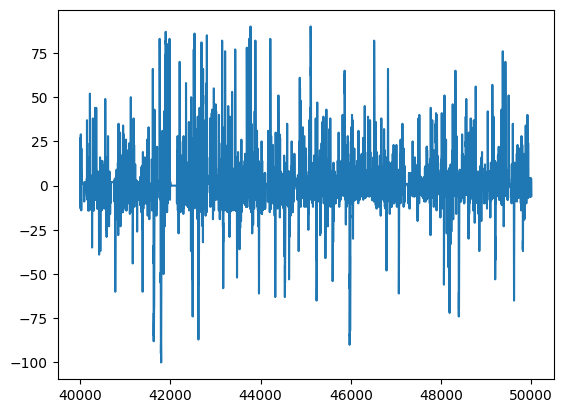

In [52]:
agent_states['assets'][-10000:].plot()

<Axes: >

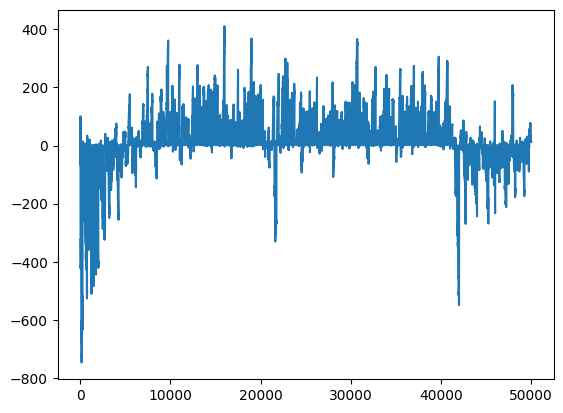

In [54]:
agent_states['equity'].plot()

<Axes: >

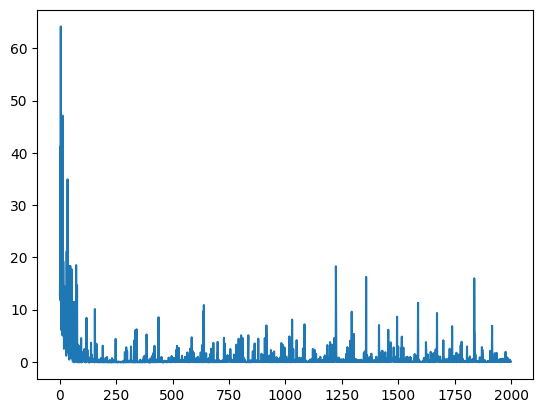

In [56]:
results_ppo_1['train/loss'].plot()

In [67]:
model.policy

ActorCriticPolicy(
  (features_extractor): customFeatureExtractor(
    (base): SimpleModel(
      (linear): Linear(in_features=16, out_features=30, bias=True)
      (linear2): Linear(in_features=30, out_features=20, bias=True)
      (linear3): Linear(in_features=20, out_features=10, bias=True)
      (linear4): Linear(in_features=10, out_features=10, bias=True)
      (softmax): Identity()
      (relu): ReLU()
    )
  )
  (pi_features_extractor): customFeatureExtractor(
    (base): SimpleModel(
      (linear): Linear(in_features=16, out_features=30, bias=True)
      (linear2): Linear(in_features=30, out_features=20, bias=True)
      (linear3): Linear(in_features=20, out_features=10, bias=True)
      (linear4): Linear(in_features=10, out_features=10, bias=True)
      (softmax): Identity()
      (relu): ReLU()
    )
  )
  (vf_features_extractor): customFeatureExtractor(
    (base): SimpleModel(
      (linear): Linear(in_features=16, out_features=30, bias=True)
      (linear2): Linear(in_fe